from susie results, what fraction of lead vars are shared with gene within 1MB?

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json
from tqdm.notebook import tqdm
from matplotlib.lines import Line2D

In [105]:
# Load in tissue colors 
with open('/home/klawren/oak/gtex/data/other_references/gtex_colors.json') as f:
    tissue_df = pd.DataFrame.from_dict(json.load(f), orient='index')
tissue_df = tissue_df.reset_index(names='tissue_name')
tissue_df['tissue_color_hex'] = '#' + tissue_df['tissue_color_hex']
tissue_color_palette = sns.color_palette(tissue_df['tissue_color_hex'])

# get the versions of tissue ids in file names
tissue_df['tissue_file_name'] = (
    tissue_df['tissue_name']
    .str.replace('(', '', regex=False)
    .str.replace(')', '', regex=False)
    .str.replace(' - ', '_')
    .str.replace(' ', '_')
)

gene_type_pal= {'lncRNA':'#b70657',
                            'sRNA':'#2D716F',
                            'pseudogene':'#734675',
                            'protein_coding':'#016895', 
                            'artifact':'grey'}

                            
gene_type_order_highlight = ['new_lncRNA', 'existing_lncRNA', 'protein_coding', 'pseudogene', 'sRNA']

# Use a lighter/greyer version for all except new_lncRNA
gene_type_pal_greyed = {
    'new_lncRNA': '#b70657',         
    'existing_lncRNA': '#d6a5b7',    
    'sRNA': '#b3c6c6',           # lighter/greyer teal
    'pseudogene': '#c2b0c6',     # lighter/greyer purple
    'protein_coding': '#a3b9c6', # lighter/greyer blue
    'artifact': '#cccccc'}        # light grey


tissue_color_map = dict(zip(tissue_df['tissue_file_name'], tissue_df['tissue_color_hex']))

In [49]:
gencode_ids = pd.read_table('/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching_lncrna_category.txt')

/local/scratch/klawren/slrmtmp.48865987/ipykernel_1192/486780901.py:1: DtypeWarning: Columns (3,5) have mixed types. Specify dtype option on import or set low_memory=False.
  gencode_ids = pd.read_table('/home/klawren/oak/gtex/data/other_references/gencode/gencode_id_matching_lncrna_category.txt')


In [ ]:
egene_results_dir = "/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_eQTL"

# load in the eSusie files
esusie = []
esusie_tissues = []
for id, row in tissue_df.iterrows():
    try:
        esusie.append(pd.read_parquet(f"{egene_results_dir}/{row['tissue_file_name']}.v11.eQTLs.SuSiE_summary.parquet"))
        esusie_tissues.append(row['tissue_file_name'])
    except:
        print(f"No eSusie results for {row['tissue_file_name']}")

No eSusie results for Artery_Aorta
No eSusie results for Artery_Coronary
No eSusie results for Artery_Femoral
No eSusie results for Artery_Tibial
No eSusie results for Brain_Anterior_cingulate_cortex_BA24
No eSusie results for Brain_Cerebellar_Hemisphere
No eSusie results for Brain_Cerebellum
No eSusie results for Brain_Cortex
No eSusie results for Brain_Frontal_Cortex_BA9
No eSusie results for Brain_Hippocampus
No eSusie results for Brain_Hypothalamus
No eSusie results for Brain_Nucleus_accumbens_basal_ganglia
No eSusie results for Brain_Putamen_basal_ganglia
No eSusie results for Brain_Spinal_cord_cervical_c-1
No eSusie results for Brain_Substantia_nigra
No eSusie results for Breast_Mammary_Tissue
No eSusie results for Cells_Cultured_fibroblasts
No eSusie results for Cells_EBV-transformed_lymphocytes
No eSusie results for Cervix_Ectocervix
No eSusie results for Cervix_Endocervix
No eSusie results for Colon_Sigmoid
No eSusie results for Colon_Transverse
No eSusie results for Esophagus

In [ ]:
esusie_df = pd.concat(esusie, keys=esusie_tissues, names=['tissue_id', 'idx'])
esusie_df = pd.merge(esusie_df, gencode_ids[['gene_id_v47', 'gene_type_grouped_highlight']], left_on='phenotype_id', right_on='gene_id_v47', how='left')
esusie_df.rename(columns={'gene_type_grouped_highlight': 'biotype', 'biotype': 'full_biotype'}, inplace=True)
esusie_df['biotype'] = np.where(esusie_df['biotype'].str.contains('lncRNA'), 'lncRNA', esusie_df['biotype'])

phenotype_id        gene_name  \
tissue_id            idx                                       
Adipose_Subcutaneous 0    ENSG00000286448.2  ENSG00000286448   
                     1    ENSG00000292994.2  ENSG00000292994   
                     2    ENSG00000292994.2  ENSG00000292994   
                     3    ENSG00000292994.2  ENSG00000292994   
                     4    ENSG00000237973.1         MTCO1P12   

                                         biotype            variant_id  \
tissue_id            idx                                                 
Adipose_Subcutaneous 0                    lncRNA   chr1_285155_A_C_b38   
                     1                    lncRNA   chr1_285155_A_C_b38   
                     2                    lncRNA   chr1_286747_A_G_b38   
                     3                    lncRNA   chr1_267812_C_T_b38   
                     4    unprocessed_pseudogene  chr1_1490110_T_C_b38   

                               pip        af  cs_id  cs_size  \
tissue_id            idx                                       
Adipose_Subcutaneous 0    0.999858  0.016878      1        1   
                     1    1.000000  0.016878      1        1   
                     2    1.000000  0.164557      2        1   
                     3    0.963508  0.016174      3        1   
                     4    0.959662  0.024613      1        1   

                                     tissue_id  
tissue_id            idx                        
Adipose_Subcutaneous 0    Adipose_Subcutaneous  
                     1    Adipose_Subcutaneous  
                     2    Adipose_Subcutaneous  
                     3    Adipose_Subcutaneous  
                     4    Adipose_Subcutaneous

In [73]:
def annotate_shared_variants_in_tissue(esusie_df: pd.DataFrame) -> pd.DataFrame:
    """
    Annotate each row with information about whether its variant is shared in >1 credible set in the tissue,
    and which other gene_ids (phenotype_ids) share variants with its credible set.
    """
    df = esusie_df.copy()
    df['cs_key'] = list(zip(df['phenotype_id'], df['cs_id']))

    # Build a mapping from gene_id (phenotype_id) to biotype for lookup
    geneid_to_biotype = df.drop_duplicates(['phenotype_id', 'biotype']).set_index('phenotype_id')['biotype'].to_dict()

    out = []
    tissue_groups = list(df.groupby('tissue_id', sort=False))
    for tissue_id, g in tqdm(tissue_groups, desc="Tissues"):
        # Map variant -> set of cs_keys containing it in this tissue
        var_to_cs = (
            g.groupby('variant_id')['cs_key']
             .apply(lambda s: set(s.unique()))
        )

        # Per-row flag: is this variant seen in >1 credible set in this tissue?
        g['variant_shared_in_tissue'] = g['variant_id'].map(lambda v: len(var_to_cs.get(v, set())) > 1)

        # Map cs_key -> set of its variants
        cs_to_variants = g.groupby('cs_key')['variant_id'].apply(set)

        # For each cs, find other cs_keys that share any variant; collect their phenotype_ids
        cs_to_shared_gene_ids = {}
        cs_to_shared_gene_biotypes = {}
        cs_items = list(cs_to_variants.items())
        for cs_key, variants in tqdm(cs_items, desc=f"CS in {tissue_id}", leave=False):
            other_cs = set()
            for v in variants:
                other_cs |= var_to_cs.get(v, set())
            other_cs.discard(cs_key)
            shared_genes = sorted({other[0] for other in other_cs})
            cs_to_shared_gene_ids[cs_key] = shared_genes
            # Get biotypes for these shared genes
            shared_biotypes = [geneid_to_biotype.get(gid, None) for gid in shared_genes]
            cs_to_shared_gene_biotypes[cs_key] = shared_biotypes

        g['cs_shared_gene_ids'] = g['cs_key'].map(cs_to_shared_gene_ids)
        g['cs_shared_gene_biotypes'] = g['cs_key'].map(cs_to_shared_gene_biotypes)
        g['cs_has_shared_variants'] = g['cs_key'].map(lambda k: len(cs_to_shared_gene_ids[k]) > 0)

        out.append(g)

    result = pd.concat(out, ignore_index=True)
    return result

In [74]:
# takes about 30 seconds per tissue
annotated = annotate_shared_variants_in_tissue(esusie_df)

Tissues:   0%|          | 0/6 [00:00<?, ?it/s]

CS in Adipose_Subcutaneous:   0%|          | 0/16831 [00:00<?, ?it/s]

CS in Adipose_Visceral_Omentum:   0%|          | 0/13031 [00:00<?, ?it/s]

CS in Adrenal_Gland:   0%|          | 0/8676 [00:00<?, ?it/s]

CS in Bladder:   0%|          | 0/1625 [00:00<?, ?it/s]

CS in Brain_Amygdala:   0%|          | 0/5515 [00:00<?, ?it/s]

CS in Brain_Caudate_basal_ganglia:   0%|          | 0/10265 [00:00<?, ?it/s]

In [177]:
# Prep: summarize to one row per credible set without hashing list columns
annotated['cs_key'] = list(zip(annotated['tissue_id'], annotated['phenotype_id'], annotated['cs_id']))

def _union_partner_biotypes(series):
    out = []
    for x in series:
        if isinstance(x, list):
            out.extend(x)
    return sorted(set(out))

# Find the lead variant (highest pip) for each cs_key
lead_variant_df = (
    annotated
    .sort_values('pip', ascending=False)
    .groupby('cs_key', as_index=False)
    .first()[['cs_key', 'variant_id']]
    .rename(columns={'variant_id': 'lead_variant_id'})
)

cs_level = (
    annotated
    .groupby('cs_key', as_index=False)
    .agg({
        'tissue_id': 'first',
        'phenotype_id': 'first',
        'cs_id': 'first',
        'biotype': 'first',  # index biotype
        'cs_has_shared_variants': 'first',  # constant per CS
        'cs_shared_gene_biotypes': _union_partner_biotypes,  # robust union
    })
    .rename(columns={'biotype': 'index_biotype'})
)

# Merge in the lead variant for each credible set
cs_level = pd.merge(cs_level, lead_variant_df, on='cs_key', how='left')

# Count partners and make pair table
cs_level['num_partners'] = cs_level['cs_shared_gene_biotypes'].apply(len)
cs_level = pd.merge(cs_level, gencode_ids[['gene_id_v47', 'lncrna_category']], left_on='phenotype_id', right_on='gene_id_v47', how='left')
cs_level['index_biotype'] = np.where(cs_level['index_biotype'] == 'lncRNA', cs_level['lncrna_category'] + '_lncRNA', cs_level['index_biotype'])

pairs = (
    cs_level
    .explode('cs_shared_gene_biotypes', ignore_index=True)
    .rename(columns={'cs_shared_gene_biotypes': 'partner_biotype'})
)
pairs['partner_biotype'] = pairs['partner_biotype'].fillna('none')

/local/scratch/klawren/slrmtmp.48865987/ipykernel_1192/2799948422.py:24: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  annot_perc = mat_prop.applymap(lambda x: f"{x*100:.1f}%" if pd.notnull(x) else "")


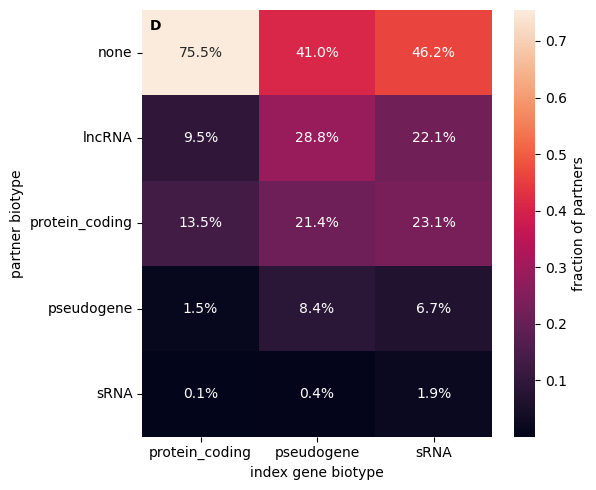

In [178]:
# Exclude 'artifact' from both index and partner biotypes
biotype_order = ['none', 'lncRNA', 'protein_coding', 'pseudogene', 'sRNA']

# Filter and group data
mat = (
    pairs[
        (pairs['index_biotype'] != 'artifact') &
        (pairs['partner_biotype'] != 'artifact')
    ]
    .groupby(['index_biotype', 'partner_biotype'], as_index=False)
    .size()
    .pivot(index='partner_biotype', columns='index_biotype', values='size')
    .fillna(0)
)

# Reindex rows and columns to desired order, keeping only those present
mat = mat.reindex(index=[b for b in biotype_order if b in mat.index])
mat = mat.reindex(columns=[b for b in biotype_order if b in mat.columns])

# Normalize by index_biotype (columns sum to 1)
mat_prop = mat.div(mat.sum(axis=0), axis=1)

# Format annotation labels as percentages with one decimal place
annot_perc = mat_prop.applymap(lambda x: f"{x*100:.1f}%" if pd.notnull(x) else "")

plt.figure(figsize=(6,5))
ax = sns.heatmap(
    mat_prop, cmap='rocket', annot=annot_perc, fmt='', 
    cbar_kws={'label': 'fraction of partners'}
)
ax.set(xlabel='index gene biotype', ylabel='partner biotype')
ax.text(0.02, 0.98, 'D', transform=ax.transAxes, ha='left', va='top', fontweight='bold')
plt.tight_layout()

In [179]:
cs_level['index_biotype'].unique()

array(['protein_coding', 'pseudogene', 'antisense_lncRNA',
       'overlapping_both_strands_lncRNA', 'intergenic_lncRNA',
       'sense_lncRNA', 'sRNA', 'other_lncRNA', 'artifact'], dtype=object)

/local/scratch/klawren/slrmtmp.48865987/ipykernel_1192/1750430670.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(


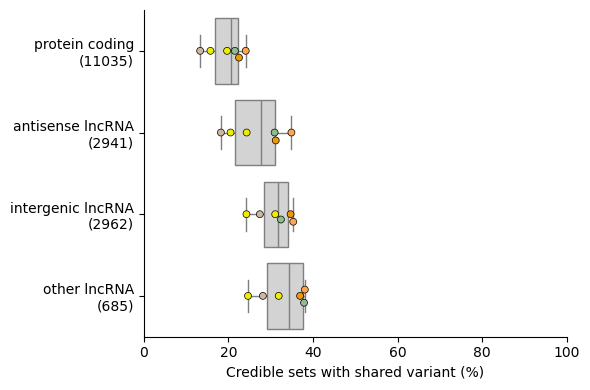

In [180]:
# Collapse 'sense_lncRNA' into 'other_lncRNA' and 'overlapping_both_strands_lncRNA' into 'antisense_lncRNA'
cs_biotype_map = {
    'protein_coding': 'protein_coding',
    'antisense_lncRNA': 'antisense_lncRNA',
    'intergenic_lncRNA': 'intergenic_lncRNA',
    'sense_lncRNA': 'other_lncRNA',
    'other_lncRNA': 'other_lncRNA',
    'overlapping_both_strands_lncRNA': 'antisense_lncRNA'
}
collapsed_biotype_order = [
    'protein_coding',
    'antisense_lncRNA',
    'intergenic_lncRNA',
    'other_lncRNA'
]

# Map biotypes and filter to relevant ones
subset = cs_level[cs_level['index_biotype'].isin(cs_biotype_map.keys())].copy()
subset['collapsed_biotype'] = subset['index_biotype'].map(cs_biotype_map)

# Calculate share rate per tissue and collapsed biotype
tissue_rate = (
    subset.groupby(['tissue_id', 'collapsed_biotype'], as_index=False)['cs_has_shared_variants']
    .mean()
    .rename(columns={'cs_has_shared_variants': 'share_rate'})
)
tissue_rate['share_rate'] = tissue_rate['share_rate'] * 100

# Calculate number of genes per collapsed biotype for labeling
biotype_counts = (
    subset.groupby('collapsed_biotype')['phenotype_id']
    .nunique()
    .reindex(collapsed_biotype_order)
)
biotype_labels = [
    f"{b.replace('_', ' ')}\n({biotype_counts[b]})" for b in collapsed_biotype_order
]

fig, ax = plt.subplots(figsize=(6, 4))

# Boxplot with y as collapsed biotype and x as share rate, protein_coding first
ax = sns.boxplot(
    data=tissue_rate,
    y='collapsed_biotype', x='share_rate',
    order=collapsed_biotype_order,
    ax=ax, zorder=0, color='lightgrey'
)

# Swarmplot with y as collapsed biotype and x as share rate, protein_coding first
sns.swarmplot(
    data=tissue_rate,
    y='collapsed_biotype', x='share_rate',
    order=collapsed_biotype_order,
    hue='tissue_id', palette=tissue_color_map,
    s=5, legend=False, ax=ax, zorder=1, linewidth=0.5, edgecolor='black'
)

ax.set_ylabel('')
ax.set_xlabel('Credible sets with shared variant (%)')
ax.set_yticklabels(
    biotype_labels,
    ha='right', rotation=0
)
ax.set_xlim(0, 100)
sns.despine()
plt.tight_layout()

/local/scratch/klawren/slrmtmp.48865987/ipykernel_1192/2086909320.py:51: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(


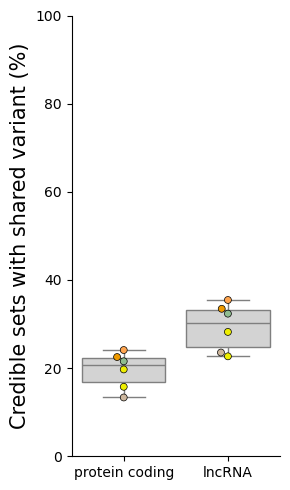

In [181]:
# Collapse all lncRNA biotypes into a single 'lncRNA' category, keep 'protein_coding' as is
cs_biotype_map = {
    'protein_coding': 'protein_coding',
    'antisense_lncRNA': 'lncRNA',
    'intergenic_lncRNA': 'lncRNA',
    'sense_lncRNA': 'lncRNA',
    'other_lncRNA': 'lncRNA',
    'overlapping_both_strands_lncRNA': 'lncRNA'
}
collapsed_biotype_order = [
    'protein_coding',
    'lncRNA'
]

# Map biotypes and filter to relevant ones
subset = cs_level[cs_level['index_biotype'].isin(cs_biotype_map.keys())].copy()
subset['collapsed_biotype'] = subset['index_biotype'].map(cs_biotype_map)

# Calculate share rate per tissue and collapsed biotype
tissue_rate = (
    subset.groupby(['tissue_id', 'collapsed_biotype'], as_index=False)['cs_has_shared_variants']
    .mean()
    .rename(columns={'cs_has_shared_variants': 'share_rate'})
)
tissue_rate['share_rate'] = tissue_rate['share_rate'] * 100

# Use simple biotype labels without sample sizes
biotype_labels = [b.replace('_', ' ') for b in collapsed_biotype_order]

fig, ax = plt.subplots(figsize=(3, 5))

# Boxplot with x as collapsed biotype and y as share rate (rotated 90 degrees)
ax = sns.boxplot(
    data=tissue_rate,
    x='collapsed_biotype', y='share_rate',
    order=collapsed_biotype_order,
    ax=ax, zorder=0, color='lightgrey'
)

# Swarmplot with x as collapsed biotype and y as share rate
sns.swarmplot(
    data=tissue_rate,
    x='collapsed_biotype', y='share_rate',
    order=collapsed_biotype_order,
    hue='tissue_id', palette=tissue_color_map,
    s=5, legend=False, ax=ax, zorder=1, linewidth=0.5, edgecolor='black'
)

ax.set_xlabel('')
ax.set_ylabel('Credible sets with shared variant (%)', fontsize=15)
ax.set_xticklabels(
    biotype_labels,
    ha='center',
)
ax.set_ylim(0, 100)
sns.despine()
plt.tight_layout()

In [166]:
pickle_path = "/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_eQTL/Adipose_Subcutaneous.v11.eQTLs.SuSiE.pickle"
susie_pickle = pd.read_pickle(pickle_path)

In [189]:
nominal_dir = "/home/klawren/oak/gtex/output/qtl/GTEx_Analysis_v11_eQTL_all_associations"
cs_level['slope'] = np.nan

# Gradually fill in the 'slope' column for cs_level by matching on tissue, gene, and variant
for tissue_id in ['Adipose_Subcutaneous', 'Adipose_Visceral_Omentum']:
    for chr_id in [*range(1, 23), 'X']:
        chr_id = f'chr{chr_id}'
        nominal = pd.read_parquet(f"{nominal_dir}/{tissue_id}.v11.allpairs.{chr_id}.parquet")
        nominal['tissue_id'] = tissue_id

        # Create a mask for rows in cs_level that match this tissue and chromosome, and have missing slope
        mask = (
            (cs_level['tissue_id'] == tissue_id) &
            (cs_level['lead_variant_id'].str.startswith(chr_id)) &
            (cs_level['slope'].isna())
        )

        # Build a mapping from (gene_id, variant_id) to slope for this chunk
        slope_map = nominal.set_index(['gene_id', 'variant_id'])['slope']

        # For each row in cs_level that matches, fill in the slope if available
        idx = cs_level.loc[mask].index
        cs_level.loc[idx, 'slope'] = cs_level.loc[idx].apply(
            lambda row: slope_map.get((row['phenotype_id'], row['lead_variant_id']), row['slope']),
            axis=1
        )
        if chr_id=='chr3':
            break


In [190]:
cs_level

,cs_key,tissue_id,phenotype_id,cs_id,index_biotype,cs_has_shared_variants,cs_shared_gene_biotypes,lead_variant_id,num_partners,gene_id_v47,lncrna_category,slope
0,"(Adipose_Subcutaneous, ENSG00000000003.16, 1)",Adipose_Subcutaneous,ENSG00000000003.16,1,protein_coding,True,[protein_coding],chrX_100649875_A_G_b38,1,ENSG00000000003.16,NaN,NaN
1,"(Adipose_Subcutaneous, ENSG00000000457.14, 1)",Adipose_Subcutaneous,ENSG00000000457.14,1,protein_coding,False,[],chr1_169788346_A_C_b38,0,ENSG00000000457.14,NaN,-0.210628
2,"(Adipose_Subcutaneous, ENSG00000000457.14, 2)",Adipose_Subcutaneous,ENSG00000000457.14,2,protein_coding,True,[protein_coding],chr1_170004194_G_A_b38,1,ENSG00000000457.14,NaN,0.325534
3,"(Adipose_Subcutaneous, ENSG00000000938.13, 1)",Adipose_Subcutaneous,ENSG00000000938.13,1,protein_coding,False,[],chr1_27634321_C_G_b38,0,ENSG00000000938.13,NaN,0.163582
4,"(Adipose_Subcutaneous, ENSG00000000971.17, 1)",Adipose_Subcutaneous,ENSG00000000971.17,1,protein_coding,False,[],chr1_196447806_GAC_G_b38,0,ENSG00000000971.17,NaN,0.239313
...,...,...,...,...,...,...,...,...,...,...,...,...
55938,"(Brain_Caudate_basal_ganglia, ENSG00000310508....",Brain_Caudate_basal_ganglia,ENSG00000310508.1,1,intergenic_lncRNA,False,[],chr6_29839124_C_G_b38,0,ENSG00000310508.1,intergenic,NaN
55939,"(Brain_Caudate_basal_ganglia, ENSG00000310508....",Brain_Caudate_basal_ganglia,ENSG00000310508.1,2,intergenic_lncRNA,False,[],chr6_29961583_T_A_b38,0,ENSG00000310508.1,intergenic,NaN
55940,"(Brain_Caudate_basal_ganglia, ENSG00000310515....",Brain_Caudate_basal_ganglia,ENSG00000310515.1,1,intergenic_lncRNA,False,[],chr6_163983901_A_G_b38,0,ENSG00000310515.1,intergenic,NaN
55941,"(Brain_Caudate_basal_ganglia, ENSG00000310517....",Brain_Caudate_basal_ganglia,ENSG00000310517.1,1,protein_coding,False,[],chr5_96660029_G_T_b38,0,ENSG00000310517.1,NaN,NaN


In [ ]:
lead_vars = annotated.groupby('')